## SAMPLE RATE 
# 16 kHz

In [6]:
import os
import ast
import pathlib
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

DATASET_PATH = "../dataframes_under_sampled/train_set.csv"
DATA_PATH = "../data/"

## EXTRACT WAVEFORMS

In [7]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, 
    # normalized to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    try :
        audio, _ = tf.audio.decode_wav(contents=audio_binary)
    except : 
        return None
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

In [8]:
dataset = pd.read_csv(DATASET_PATH)
print(dataset.shape)
dataset.head()

(20908, 3)


,filename,label,set
0,113b3fbc_nohash_3.wav,on,training
1,cc3b5b62_nohash_3.wav,left,training
2,96d8bb6f_nohash_0.wav,nine,training
3,789e4ee7_nohash_0.wav,sheila,training
4,f618568f_nohash_0.wav,six,training


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
dataset['waveform'] = dataset.apply(lambda row: decode_audio(tf.io.read_file(DATA_PATH + row['label'] + "/" + row['filename'])), axis=1)

In [ ]:
dataset

,filename,label,set,waveform
0,113b3fbc_nohash_3.wav,on,training,"(tf.Tensor(0.0012207031, shape=(), dtype=float..."
1,cc3b5b62_nohash_3.wav,left,training,"(tf.Tensor(-6.1035156e-05, shape=(), dtype=flo..."
2,96d8bb6f_nohash_0.wav,nine,training,"(tf.Tensor(-0.00033569336, shape=(), dtype=flo..."
3,789e4ee7_nohash_0.wav,sheila,training,"(tf.Tensor(-0.000579834, shape=(), dtype=float..."
4,f618568f_nohash_0.wav,six,training,"(tf.Tensor(0.0009765625, shape=(), dtype=float..."
...,...,...,...,...
20903,e7bcee8a_nohash_0.wav,backward,training,"(tf.Tensor(3.0517578e-05, shape=(), dtype=floa..."
20904,4e8c5516_nohash_1.wav,yes,training,"(tf.Tensor(-0.00015258789, shape=(), dtype=flo..."
20905,6cf5459b_nohash_2.wav,tree,training,"(tf.Tensor(-0.0018005371, shape=(), dtype=floa..."
20906,f618568f_nohash_0.wav,yes,training,"(tf.Tensor(-3.0517578e-05, shape=(), dtype=flo..."


In [ ]:
dataset = dataset.dropna()

In [ ]:
print(dataset.waveform[0])
type(dataset.waveform[0])

tf.Tensor(
[ 0.0012207   0.00115967  0.00109863 ... -0.00143433 -0.00149536
 -0.0015564 ], shape=(16000,), dtype=float32)


tensorflow.python.framework.ops.EagerTensor

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20907 entries, 0 to 20907
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  20907 non-null  object
 1   label     20907 non-null  object
 2   set       20907 non-null  object
 3   waveform  20907 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


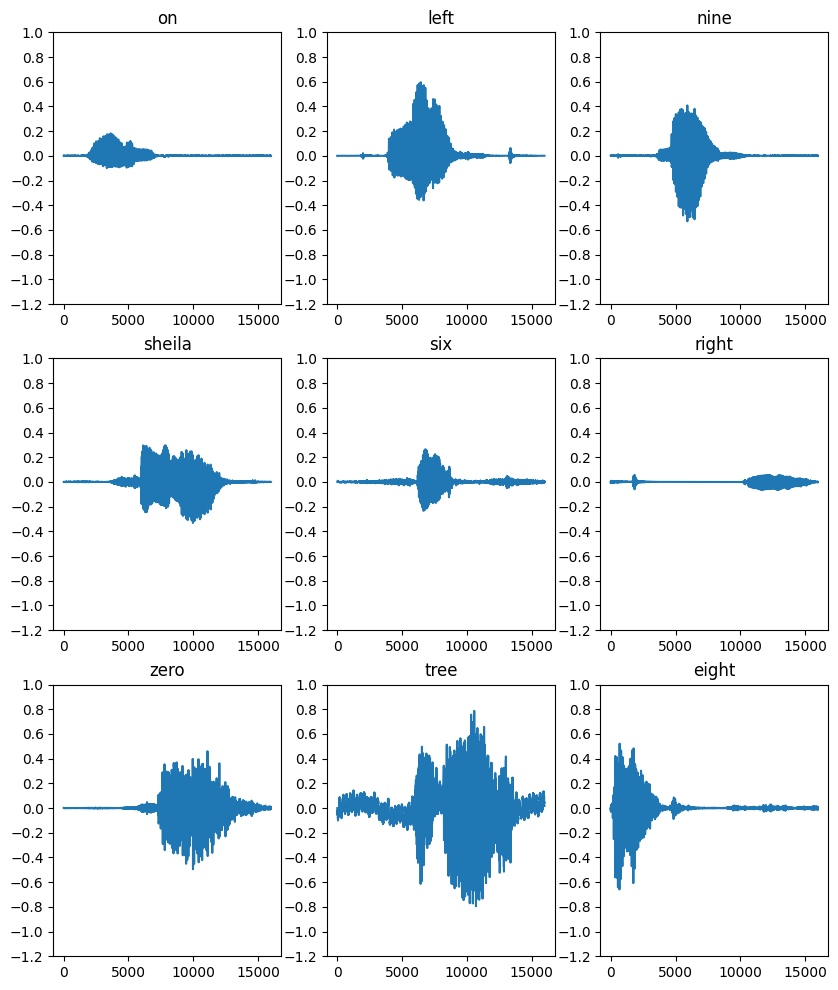

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
labels = dataset.label[0:n].values.tolist()
waveforms = dataset.waveform[0:n].values.tolist()
for i, (audio, label) in zip(range(n), zip(waveforms, labels)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    # label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## WAVEFORMS TO SPECTROGRAMS

In [ ]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [ ]:
dataset.waveform[0]

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([ 0.0012207 ,  0.00115967,  0.00109863, ..., -0.00143433,
       -0.00149536, -0.0015564 ], dtype=float32)>

In [ ]:
dataset.label[0]

'on'

In [ ]:
waveform, label = dataset.waveform[0], dataset.label[0]

In [ ]:
spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: on
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

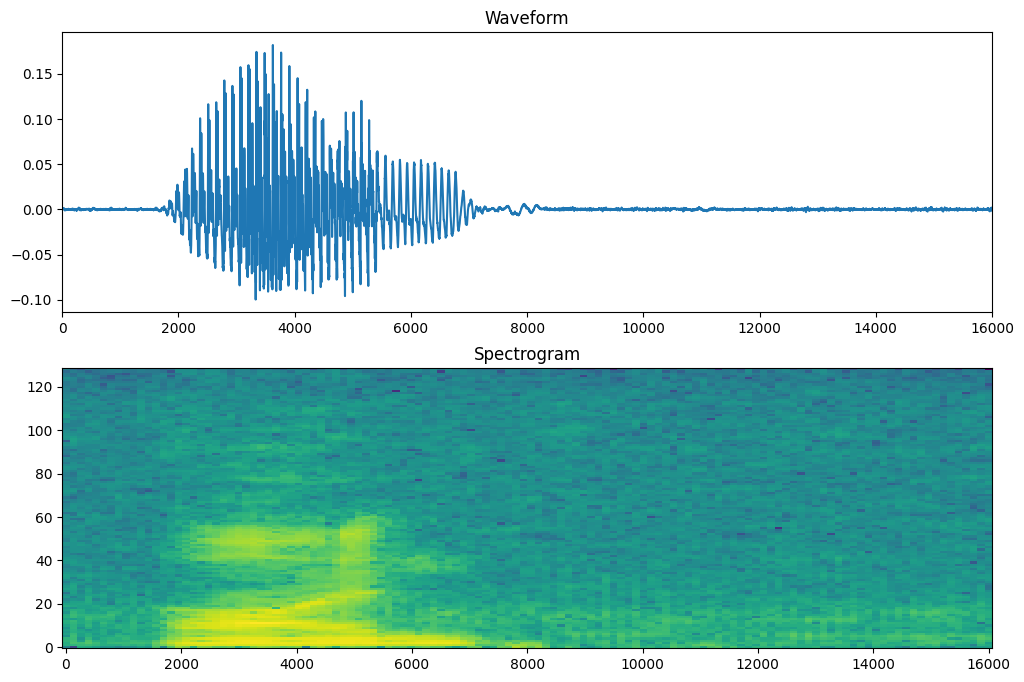

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
dataset['spectrogram'] = dataset['waveform'].apply(lambda x: get_spectrogram(x))

: 

: 

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
labels = dataset.label[0:n].values.tolist()
waveforms = dataset.waveform[0:n].values.tolist()
for i, (spectrogram, label) in zip(range(n), zip(waveforms, labels)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(label)
    ax.axis('off')

plt.show()

In [1]:
import os
import pathlib
import pandas as pd

# import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
# from IPython import display


def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, 
    # normalized to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    try :
        audio, _ = tf.audio.decode_wav(contents=audio_binary)
    except : 
        return None
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


2023-01-23 18:27:26.066567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 18:27:26.597200: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-23 18:27:26.597275: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-23 18:27:27.973474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# DATASET_PATH = "full_df.csv"
DATASET_PATH = "../dataframes/full_df.csv"
# DATA_PATH = "/home/lagarrueal/voice_commands/data/"
DATA_PATH = "/home/lagarrueal/voice_commands/VoiceCommands/data/"
COMMANDS = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "_background_noise_"]
TARGETS = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "unknown", "_background_noise_"]

dataset = pd.read_csv(DATASET_PATH)
print(dataset.shape)
dataset = dataset.head(25)
AUTOTUNE = tf.data.AUTOTUNE

print("Starting to decode audio files...")
dataset['waveform'] = dataset.apply(lambda row: decode_audio(tf.io.read_file(DATA_PATH + row['label'] + "/" + row['filename'])), axis=1)
dataset = dataset.dropna()
dataset = dataset.reset_index(drop = True)
print("Starting to convert audio files to spectrograms...")
dataset['spectrogram'] = dataset['waveform'].apply(lambda x: get_spectrogram(x))
print("Transforming labels")
dataset['label'] = dataset['label'].apply(lambda x: x if x in COMMANDS else "unknown")

batch_size = 128
train_ds = dataset[dataset['set'] == 'training']
train_ds = train_ds.reset_index(drop = True)
val_ds = dataset[dataset['set'] == 'validation']
val_ds = val_ds.reset_index(drop = True)
test_ds = dataset[dataset['set'] == 'testing']
test_ds = test_ds.reset_index(drop = True)

(105836, 3)
Starting to decode audio files...
Starting to convert audio files to spectrograms...


2023-01-23 18:27:33.678639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 18:27:33.679009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-23 18:27:33.679129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-23 18:27:33.679206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-23 18:27:33.679263: W tensorf

Transforming labels


In [3]:
for spectrogram in train_ds['spectrogram'][0:1]:
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(TARGETS)
print(num_labels)

Input shape: (124, 129, 1)
12


In [10]:
type(train_ds['spectrogram'][0])

tensorflow.python.framework.ops.EagerTensor

In [19]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data = train_ds['spectrogram'])

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

print(model.summary())

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

metrics = history.history

test_audio = []
test_labels = []

for audio, label in zip(test_ds['waveform'], test_ds['label']):
    test_audio.append(audio.numpy())
    test_labels.append(label)

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

model.save('model_cnn.h5')

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tensorflow.python.framework.ops.EagerTensor).